<a href="https://colab.research.google.com/github/swati-git/FineTuneLLM/blob/main/Supervised_Fine_Tuning_With_FinancialSentiment_on_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers>=4.46.0

In [ ]:
!pip install pipdeptree

In [ ]:
!pipdeptree --packages transformers

# For reverse dependencies (what depends on this package)
#!pipdeptree -r --packages transformers

In [ ]:
#!pip freeze | grep transformers

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model = AutoModelForCausalLM.from_pretrained(
    "facebook/OPT-1.3b",
    torch_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(
    "facebook/OPT-1.3b"
    )

**Initialize the training dataset using**
[Financial Sentiment Data](hub://genai360/FingGPT-sentiment-train-set)

In [ ]:
!pip install deeplake==3.6.19

In [ ]:
import deeplake

ds = deeplake.load('hub://genai360/FingGPT-sentiment-train-set')
ds

The data from deeplake as represented below.

As we can see , the size of records in "input" column varies across the dataset.Handling variable-length inputs adds computational overhead therefore we will use **ConstantLengthDataset** [ConstantLengthDataset](https://github.com/huggingface/trl/blob/main/trl/trainer/utils.py#L546) that aims to reduce the computational overhead by converting variable-length sequences to fixed-length chunks.
A constant length sequence eliminates need for dynamic padding during processing.
This can be achieved by setting seq_length=1024



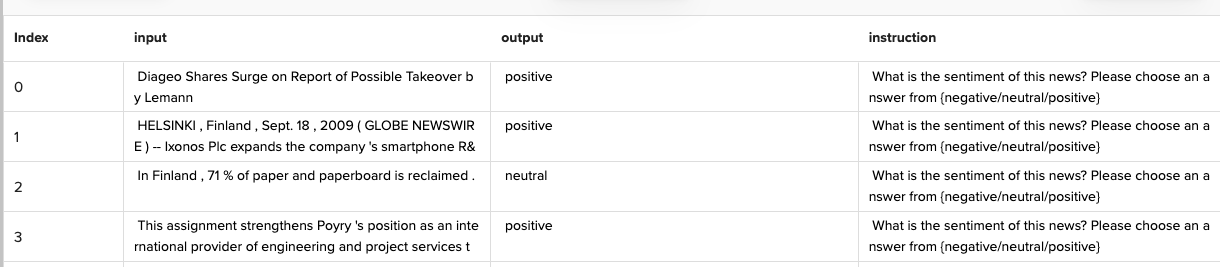

The training dataset will be formatted in order to represent a **template** that the model can use to learn and recognize that a **prompt** beginning with the **question** keyword should be completed with an **answer**

In [4]:
def prepare_template(data):
  template = f"{data['instruction'].text()}\n\nContent: {data['input'].text()}\n\nSentiment: {data['output'].text()}"
  return template

In [ ]:
!pip install trl==0.15.2

In [9]:
from trl.trainer import ConstantLengthDataset

train_dataset = ConstantLengthDataset(
    tokenizer,
    ds,
    formatting_func=prepare_template,
    infinite=True,
    seq_length=1024
)

In [ ]:
ds_eval = deeplake.load('hub://genai360/FingGPT-sentiment-valid-set')

eval_dataset = ConstantLengthDataset(
    tokenizer,
    ds_eval,
    formatting_func=prepare_template,
    infinite=True,
    seq_length=1024
)

In [ ]:
!pip install peft==0.5.0

In [12]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
lora_config

In [1]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [2]:
!pip install wandb -qU

In [3]:
import wandb

In [7]:
import os

from google.colab import userdata
os.environ["WANDB_API_KEY"] = userdata.get('wandb_api_ky')

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
    packing=True,
)